# GreenGuardian 🌎🛡️

Green Guardian utilizes AWS SageMaker and associated cloud technologies to deploy an advanced deep learning model for precise plastic object detection in images. Through SageMaker, the model is efficiently trained and tuned. The detection process is orchestrated using Step Functions, triggered by AWS EventBridge's CRON jobs on scheduled intervals. This approach enables cost-effective, scalable, and accurate plastic detection, aligning with the goal of a greener planet!

In [2]:
# module imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
from IPython.display import display
from PIL import Image

## DATA ANALYSIS 📊:

In [3]:
# create a dataframe for the train and validation imgs:
print("VALIDATION IMGS RAW LABEL DATA:")
df_val = pd.read_csv('data/validation/labels/detections.csv')
display(df_val.head())

print("\nTRAIN IMGS RAW LABEL DATA:")
df_train = pd.read_csv('data/train/labels/detections.csv')
display(df_train.head())

VALIDATION IMGS RAW LABEL DATA:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0



TRAIN IMGS RAW LABEL DATA:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


### DATA ANALYSIS NOTE #1:

- The CSV-data extracted above for the training labels and validation labels contains information about **all** the classes in the dataset we acquired from Google's Open Images Dataset.

- I will be restricting this data to contain information about the images that have **only** the unique **label_name** corresponding to plastic-images for this project's purpose, as we do not care about other types of images, this model is solely aimed to be trained on the bounding boxes drawn around the plastic entities in the image.

- In the code below, I've retrieved how many images we're working with for each type, and filtered them out by img-id for further use.

In [ ]:
# paths to the training and validation images.
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# lists to store the respective img ids.
train_img_ids = []
val_img_ids = []

# total amt of img analysis.
def count_total_imgs():
    
    # img counters.
    total_val_imgs = 0
    total_train_imgs = 0

    # counter-loop.
    img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]
    for path in img_paths:
        if('validation' in path):
            for img in glob.glob(path):
                total_val_imgs += 1
        if('train' in path):
            for img in glob.glob(path):
                total_train_imgs += 1

    print("THE TOTAL NUMBER OF VALIDATION IMGS IS: ", total_val_imgs)
    print("THE TOTAL NUMBER OF TRAIN IMGS IS: ", total_train_imgs)

# retrieving each img-id from each of the paths.
def get_desired_img_ids(path):
    
    # retrieval.
    for img in glob.glob(path):
        if 'train' in path:
            img_id = img.split("/")[-1].split(".")[0]
            train_img_ids.append(img_id)
        elif 'validation' in path:
            img_id = img.split("/")[-1].split(".")[0]
            val_img_ids.append(img_id)

# func calls.
count_total_imgs()
for path in img_paths:
    get_desired_img_ids(path)

THE TOTAL NUMBER OF VALIDATION IMGS IS:  9
THE TOTAL NUMBER OF TRAIN IMGS IS:  517


### DATA ANALYSIS NOTE #2:

- As stated before, I will be restricting this data to contain information about the images that have **only** the unique **label_name** corresponding to plastic-images. Hence let's extract the given class identifier for the plastic images, and filter only those in our raw data.

- I've also included a visualization for how the csv data of a randomly chosen img-id from our desired class identifier would look.

In [6]:
df_val_classes = pd.read_csv('data/validation/metadata/classes.csv', names = ['className', 'Object'])
df_train_classes = pd.read_csv('data/train/metadata/classes.csv', names = ['className', 'Object'])

val_plastic_class_identifier = df_val_classes[df_val_classes['Object'] == 'Plastic bag']
train_plastic_class_identifier = df_train_classes[df_train_classes['Object'] == 'Plastic bag']

print(val_plastic_class_identifier, "----> Plastic Class Identifier for Validation Images")
print("\n", train_plastic_class_identifier, "----> Plastic Class Identifier for Training Images")

     className       Object
327  /m/05gqfk  Plastic bag ----> Plastic Class Identifier for Validation Images

      className       Object
327  /m/05gqfk  Plastic bag ----> Plastic Class Identifier for Training Images


In [15]:
# img paths.
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# func to sample a random row with the desired class identifier -- /m/05gqfk
def sample_random_row_from_df(path):
    
    df = ""
    if 'train' in path:
        df,ids_to_check = df_train, train_img_ids # 517 imgs in train_img_ids.
    elif 'validation' in path:
        df,ids_to_check = df_val, val_img_ids # 9 imgs in val_img_ids.
    
    img_ids_len = len(ids_to_check)
    rand = random.randint(0,img_ids_len-1)
    id = ids_to_check[rand]
    print(id)
    r = df.loc[(df.ImageID == id) & (df.LabelName == '/m/05gqfk')]
    print(r)

sample_random_row_from_df(img_paths[1])

255ae4b60de75bf9
                  ImageID  Source  LabelName  Confidence      XMin      XMax  \
2335024  255ae4b60de75bf9  xclick  /m/05gqfk           1  0.001251  0.999375   

         YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
2335024   0.0  0.998888           0            1  ...            0         0   

         XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
2335024  0.497811  0.999375  0.744841  0.001251       0.0  0.372636  0.998888   

         XClick4Y  
2335024  0.588432  

[1 rows x 21 columns]


## DATA VISUALIZATION 📷

- Let's randomly visualize a few images from the training and validation data-sets to see the type of data we're dealing with, essentially let's see what types of "plastic images" we have!

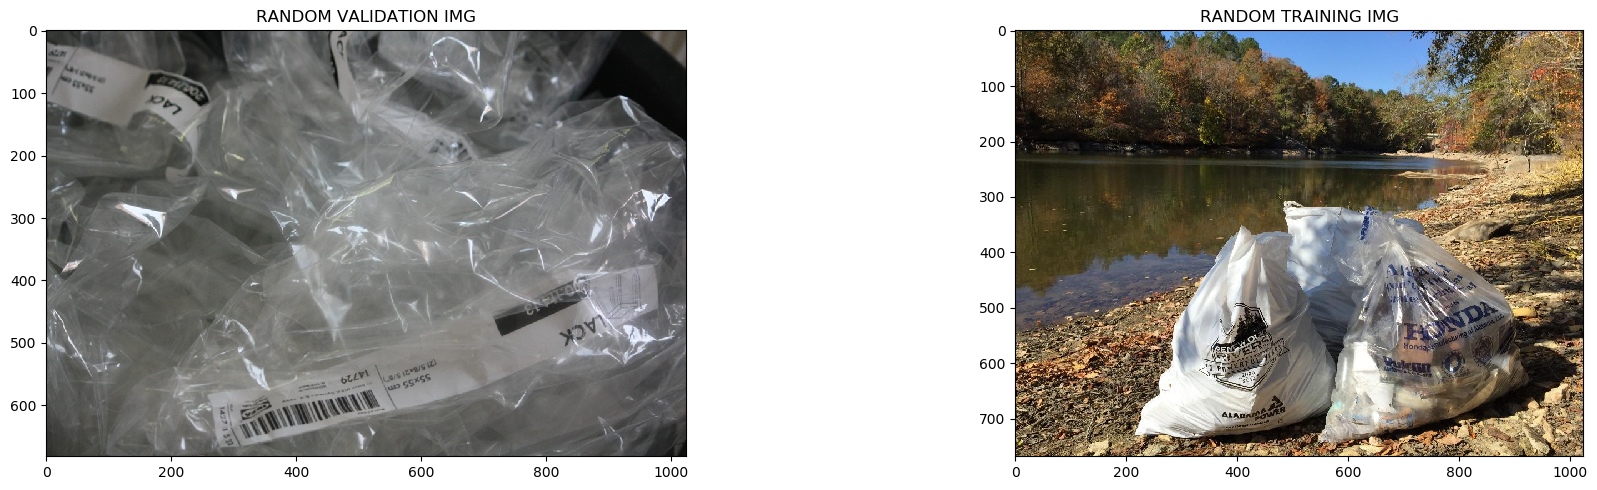

In [36]:
# img paths
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# visualizer func.
def visualize_imgs(paths):
    
    # set-up plot.
    num_imgs = len(paths)
    fig, axes = plt.subplots(1, num_imgs, figsize=(10 * num_imgs, 5))
    
    # run the for-loop to pick a random img out of each of the two paths.
    for i, path in enumerate(paths):
        img_list = glob.glob(path)
        random_img = mpimg.imread(img_list[random.randint(0, len(img_list) - 1)])
        ax = axes[i] if num_imgs > 1 else axes 
        if 'validation' in path:
            ax.set_title("RANDOM VALIDATION IMG")
        if 'train' in path:
            ax.set_title("RANDOM TRAINING IMG")
        ax.imshow(random_img)

    plt.tight_layout()  # To prevent overlapping labels and titles
    plt.show()

# call function.
visualize_imgs(img_paths)

## APPLYING BOUNDING BOXES TO THE PLASTIC IMAGES ⏹️

**Purpose of Bounding Boxes**:

- Bounding boxes are used to mark regions of interest or objects within an images (our region of interest is the plastic within the images) These boxes are defined by coordinates and dimensions. Within the **detections.csv** data for the training and validation images, we're given the following information: (XMin, XMax, YMin, YMax).

**Coordinate System and Scaling**:

- The variables listed above are the bounding box coordinates and are given as fractions between 0 and 1, rather than pixel values. These fractional coordinates need to be scaled to match the dimensions of the actual image.

- To scale the bounding box coordinates, we essentially want to:
    - Take the given fractional x-coordinates (x_min and x_max) and multiply by the image width to get the actual pixel values for the left and right sides of the bounding box.
    - Take the given fractional y-coordinates (y_min and y_max) and multiply by the image height to get the actual pixel values for the top and bottom sides of the bounding box.
    
**Creating the Bounding Box**:

- We're going to use the Matplotlib library to visualize the bounding boxes. Rectangle's are to be used as the "bounding box" using the patches.rectangle function from Matplotlib. This function takes the scaled coordinates, width, and height as arguments to draw the bounding box.

The goal is to automate the details stated above for all the images in the training and validation images folder inside the dataset.
In the code below, lets write a function to draw bounding boxes around the plastic entities within random images from each training and validation dataset.

THE PATH OF THE RANDOM IMG SELECTED IS:  data/train/data/1f1f12e2448553e0.jpg
THE RANDOM IMG'S ID IS:  1f1f12e2448553e0


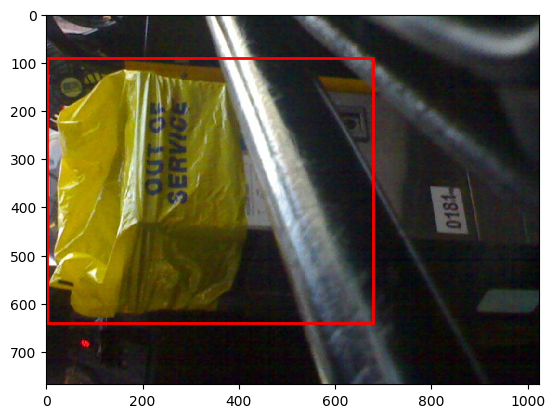

In [43]:
# img paths
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# func to draw bounding boxes around randomly selected images in the training and validation datasets.
def draw_bounding_boxes(path):
    
    # assigning the appropriate datasets.
    if 'train' in path:
        df = df_train
    elif 'validation' in path:
        df = df_val
    
    # retrieve list of paths of all the imgs within the current dataset split.
    all_imgs_list = glob.glob(path)
    
    # select a random img to draw the bounding-box around, and retrieve its id.
    random_img = all_imgs_list[random.randint(0, len(all_imgs_list) - 1)]
    random_img_id = random_img.split("/")[-1].split(".")[0]
    print("THE PATH OF THE RANDOM IMG SELECTED IS: ", random_img)
    print("THE RANDOM IMG'S ID IS: ", random_img_id)
    
    # selecting only the rows where the data matches our requirements. 
    # our requirements are the random img to draw the bounding boxes around, and the plastic class identifier.
    img = Image.open(random_img)
    desired_df_rows = df_rows = df.loc[(df.ImageID == random_img_id) & (df.LabelName == '/m/05gqfk')]
    
    img_width, img_height = img.size
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    for idx, row in desired_df_rows.iterrows():
        
        curr_xmin = row['XMin']
        curr_xmax = row['XMax']
        curr_ymin = row['YMin']
        curr_ymax = row['YMax']
        # print(curr_xmin)
        # print(curr_xmax)
        # print(curr_ymin)
        # print(curr_ymax)
        
        new_xmin = curr_xmin * img_width
        new_xmax = curr_xmax * img_width
        new_ymin = curr_ymin * img_height
        new_ymax = curr_ymax * img_height
        
        width = new_xmax - new_xmin
        height = new_ymax - new_ymin
        
        rect = patches.Rectangle((new_xmin,new_ymin), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()
    
draw_bounding_boxes(img_paths[1])

## CLEANING AND SPLITTING OUR DATA 🧹

- Essentially, our goal is to retain only pertinent information from the '**detections.csv**' file for the training and validation images. The information that we're going to filter based off to 'clean' the .csv's is the images that contain our desired plastic class identifier: '/m/05gqfk'.

- When running the code to check the length of the cleansed dataframes for each split, we get a number out, which represents the total amount of "proper" rows in the df (proper rows is defined as: rows that have plastic data in them with which we can draw bounding boxes around for the respective image). 

In [54]:
def clean_csv_files(df_train_cleansed, df_val_cleansed):
    df_train_cleansed = df_train[df_train['LabelName'].str.contains('/m/05gqfk')]
    df_val_cleansed = df_val[df_val['LabelName'].str.contains('/m/05gqfk')]
    
    return df_train_cleansed, df_val_cleansed

df_train_cleansed, df_val_cleansed = clean_csv_files(df_train, df_val)
print("THERE ARE:", len(df_train_cleansed), "CLEANSED TRAINING PLASTIC ROWS WITH BOUNDING BOXES.")
print("THERE ARE:", len(df_val_cleansed), "CLEANSED VALIDATION PLASTIC ROWS WITH BOUNDING BOXES.")

THERE ARE: 366 CLEANSED TRAINING IMAGES WITH BOUNDING BOXES.
THERE ARE: 9 CLEANSED VALIDATION IMAGES WITH BOUNDING BOXES.


In [56]:
df_train_cleansed

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
8282,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
8733,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
10247,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
12496,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
40914,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887478,4027450a277803ff,xclick,/m/05gqfk,1,0.000000,0.999167,0.000000,0.999375,0,1,...,0,0,0.623333,0.999167,0.503333,0.000000,0.000000,0.544375,0.999375,0.596875
3896767,404d92e51549f991,xclick,/m/05gqfk,1,0.000000,0.571875,0.000000,0.279167,1,1,...,0,0,0.186875,0.099375,0.000000,0.571875,0.000000,0.279167,0.098333,0.000000
3896768,404d92e51549f991,xclick,/m/05gqfk,1,0.879375,0.999375,0.000000,0.211667,0,1,...,0,0,0.972500,0.879375,0.996875,0.999375,0.000000,0.125833,0.211667,0.175833
3904835,407143f172757997,xclick,/m/05gqfk,1,0.223438,0.584375,0.754167,0.997917,0,1,...,0,0,0.287500,0.223438,0.509375,0.584375,0.754167,0.818750,0.997917,0.997917
